In [1]:
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import os
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import json

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from scipy.stats import chi2

In [2]:
path = 'minimal_pkls/'
save_path = 'phi_stats/'
os.makedirs(save_path, exist_ok=True)
files = os.listdir(path)
len(files)

200

In [3]:
from social_phi import get_signal, experiment_hop_range

def flatten(l : list):
    return [item for sublist in l for item in sublist]

def run_experiment(file, time_scale=24*3600, window=30):
    if os.path.exists(save_path + file[:-4] + '.csv'):
        return
    
    data = pickle.load(open(path + file, 'rb'))
    sig = get_signal(data['activities'], time_scale=time_scale, binarize=True)
    stats = experiment_hop_range(sig=sig, window=window, min_hop=1, max_hop=window, silent=True)
    stats.to_csv(save_path + file[:-4] + '.csv', index=False)
    
    
def load_data(file):
    stats = pd.read_csv(save_path + file[:-4].replace('____', '-') + '.csv')
    data = pickle.load(open(path + file, 'rb'))
    act = flatten(data['activities'].values())
    
    return {
#         'file' : file[:-4],
        'forks' : data['forks'],
        'stars' : data['stars'],
        'open_issues' : np.sum(data['issues_state']),
        'closed_issues' : len(data['issues_state']) - np.sum(data['issues_state']),
        'avg_issue_survival' : np.mean(data['issues_lifetime']),
        'users' : len(data['activities']),
        'total_commits' : len(act),
        'timeline_length' : (max(act) - min(act)) // (24*3600),
        'avg_phi' : stats.loc[np.argmax(stats['avg_phi']*stats['vnr'])].avg_phi
    }

In [10]:
# from joblib import Parallel, delayed

# _ = Parallel(n_jobs=20)(delayed(run_experiment)(file) for file in tqdm(files))

In [4]:
df = pd.DataFrame(columns=['forks', 'stars', 'open_issues', 'closed_issues', 'avg_issue_survival', 'users', 'total_commits', 'timeline_length', 'avg_phi'])
for file in tqdm(os.listdir(path)):
    if '____' in file:
        df = df.append(load_data(file), ignore_index=True)
df = df.astype(float)
print(df.shape)
df.head()


(113, 9)


,forks,stars,open_issues,closed_issues,avg_issue_survival,users,total_commits,timeline_length,avg_phi
0,9669.0,50595.0,458.0,30422.0,31.287791,3705.0,18070.0,2224.0,0.766809
1,11285.0,47617.0,398.0,11949.0,28.894144,851.0,7287.0,968.0,1.367960
2,4941.0,54969.0,679.0,10578.0,79.191969,436.0,12317.0,2928.0,0.954854
3,12885.0,48550.0,1248.0,7467.0,173.386460,731.0,7398.0,4695.0,0.944185
4,5169.0,42490.0,131.0,11304.0,107.776476,460.0,17134.0,3499.0,0.842548


## issue survival analysis

In [96]:
# all_issues_lifetime = []
# for file in df['file']:
#     if '____' in file:
#         data = pickle.load(open(path + file + '.pkl', 'rb'))
#         all_issues_lifetime += [data['issues_lifetime']]

# m = min(flatten(all_issues_lifetime))
# M = max(flatten(all_issues_lifetime))
# n_bins = 100
# issue_bins = np.linspace(m, M + 1, n_bins + 1)
# issues_survival = np.array([np.histogram(lifetime, issue_bins)[0] for lifetime in all_issues_lifetime])
# mean_issues_survival = np.array([np.mean(lifetime) for lifetime in all_issues_lifetime])

# scale = MinMaxScaler()
# #StandardScaler()

# pca = PCA(n_components=1).fit(issues_survival)
# cum_var = np.cumsum(pca.explained_variance_ratio_)
# issue_life_comps = pca.transform(issues_survival)
# print(cum_var[-1])

# plt.figure(figsize=(20,5))
# plt.subplot(1,2,1)
# plt.title('pc1')
# scaled_comps = scale.fit_transform(issue_life_comps)
# plt.hist(scaled_comps, 100)

# plt.subplot(1,2,2)
# plt.title('mean')
# scaled_means = scale.fit_transform(mean_issues_survival.reshape(-1,1))
# plt.hist(scaled_means, 100)
# print('means var:',np.var(scaled_means), ' comps var:', np.var(scaled_comps))
# # plt.scatter(issue_life_comps[:,0], issue_life_comps[:,1])
# plt.show()

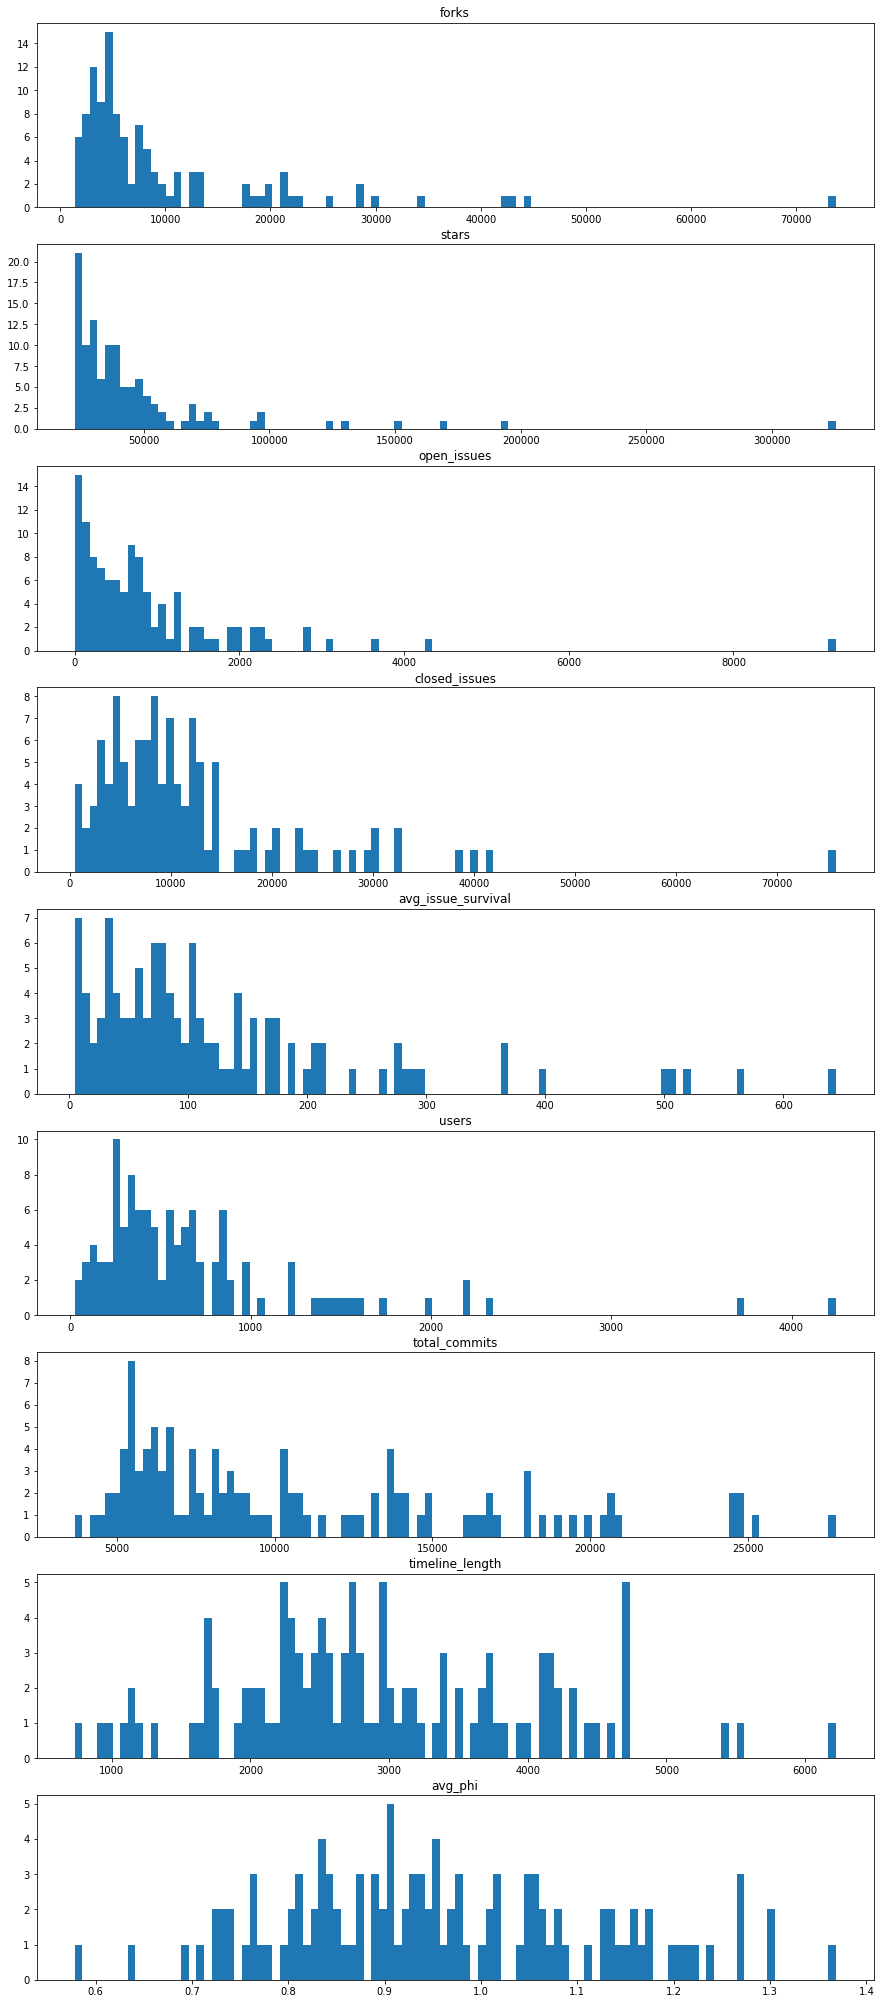

In [5]:
bins = 100
n = len(df.columns)

plt.figure(figsize=(15,n*4))
for i,col in enumerate(df.columns):
    plt.subplot(n,1,i+1)
    plt.title(col)
    plt.hist(df[col], bins)

plt.show()

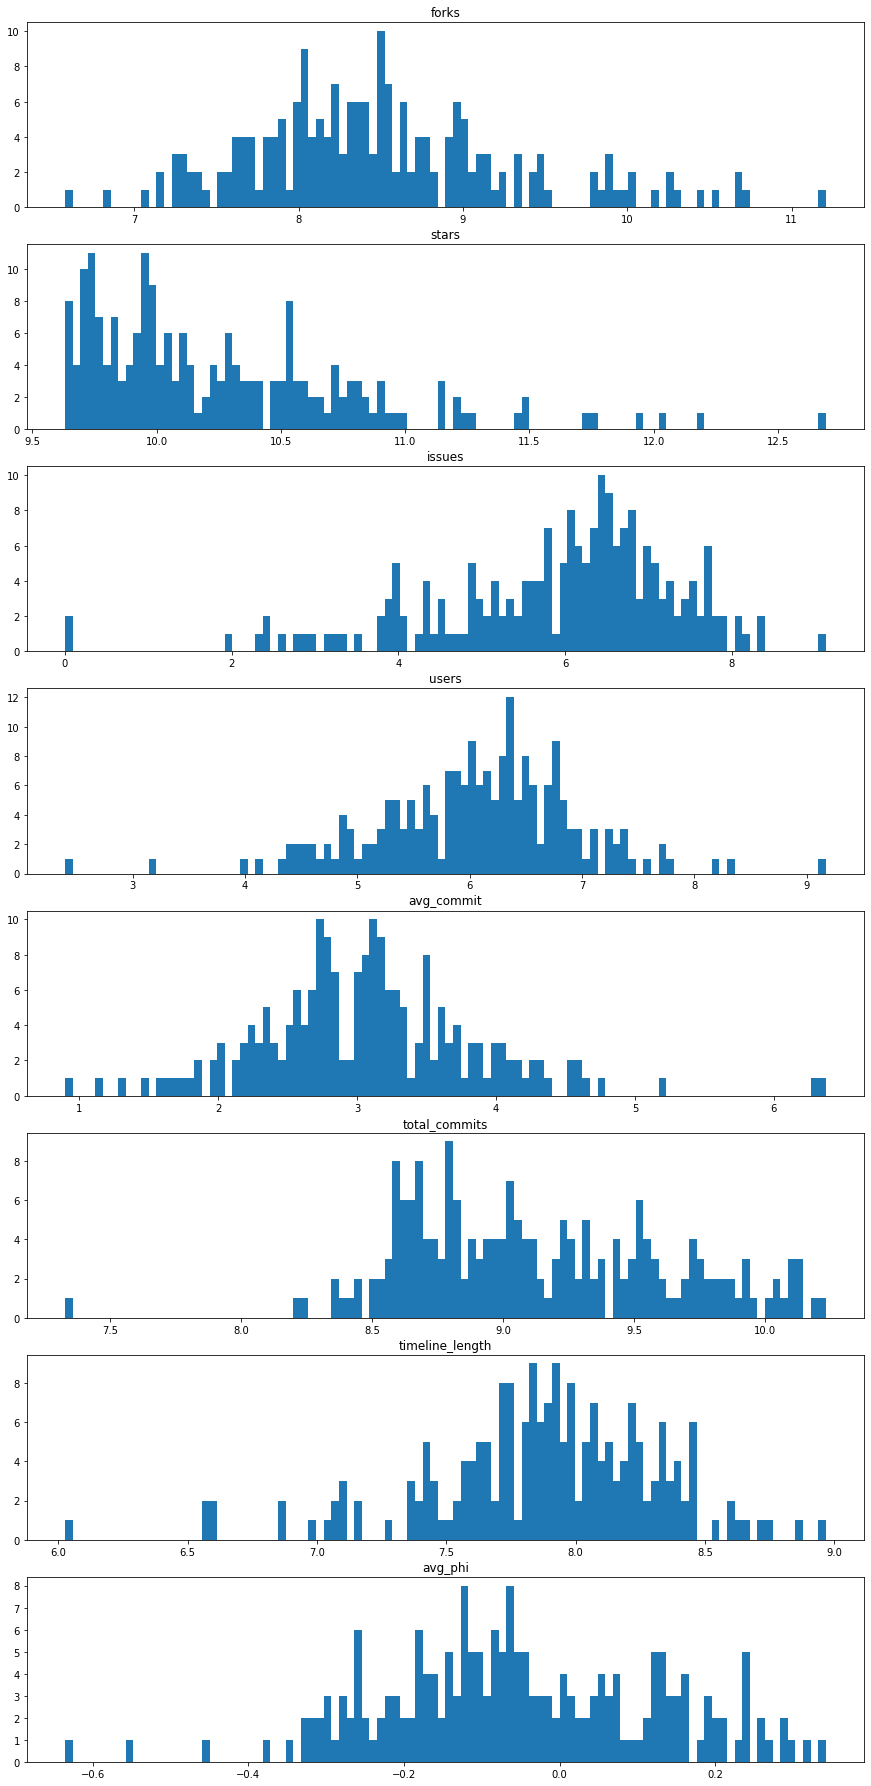

In [316]:
log_df = df.copy()
for col in log_df.columns:
    log_df = log_df[log_df[col] > 0]
    log_df[col] = np.log(log_df[col])
    
bins = 100
n = len(df.columns)

plt.figure(figsize=(15,n*4))
for i,col in enumerate(df.columns):
    plt.subplot(n,1,i+1)
    plt.title(col)
    plt.hist(log_df[col], bins)

plt.show()

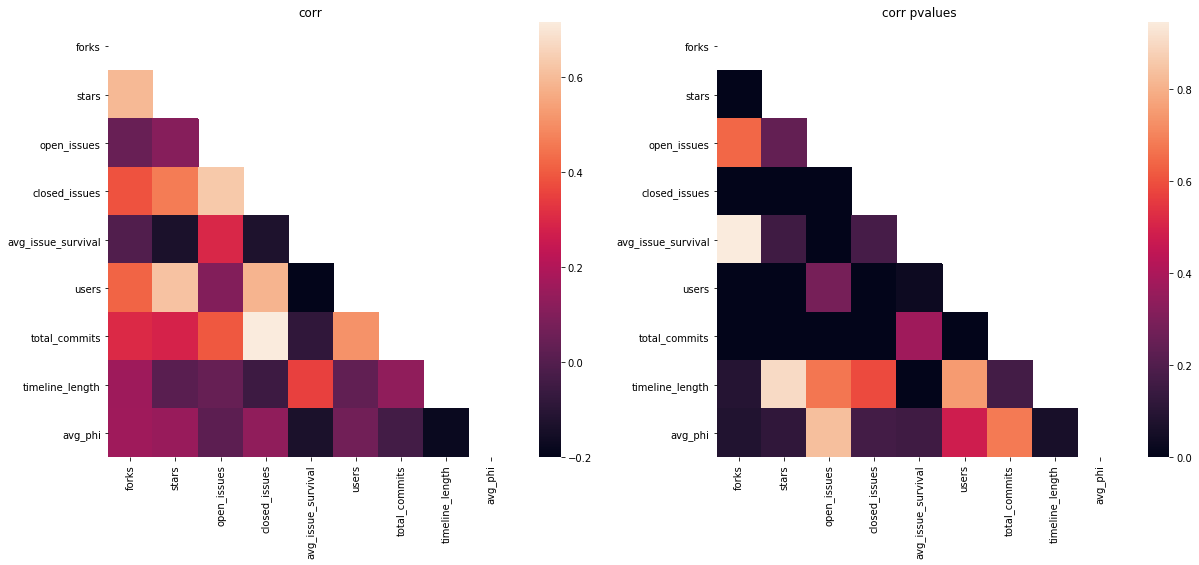

In [6]:
from scipy import stats as sci_stats
from sklearn.metrics import mutual_info_score, normalized_mutual_info_score, adjusted_mutual_info_score

plt.figure(figsize=(20,8))
plt.subplot(1,2,1)
plt.title('corr')
corrs = df.corr()
sns.heatmap(corrs, mask=np.triu(np.ones(df.shape[1])))

corr_tvals = corrs * np.sqrt(df.shape[0] - 2) / np.sqrt(1 - corrs**2)
corr_pvals = sci_stats.t.sf(np.abs(corr_tvals), df.shape[0] - 2)*2
corr_pvals = pd.DataFrame(corr_pvals, columns=df.columns, index=df.columns)


plt.subplot(1,2,2)
plt.title('corr pvalues')
sns.heatmap(corr_pvals, mask=np.triu(np.ones(df.shape[1])))

plt.show()

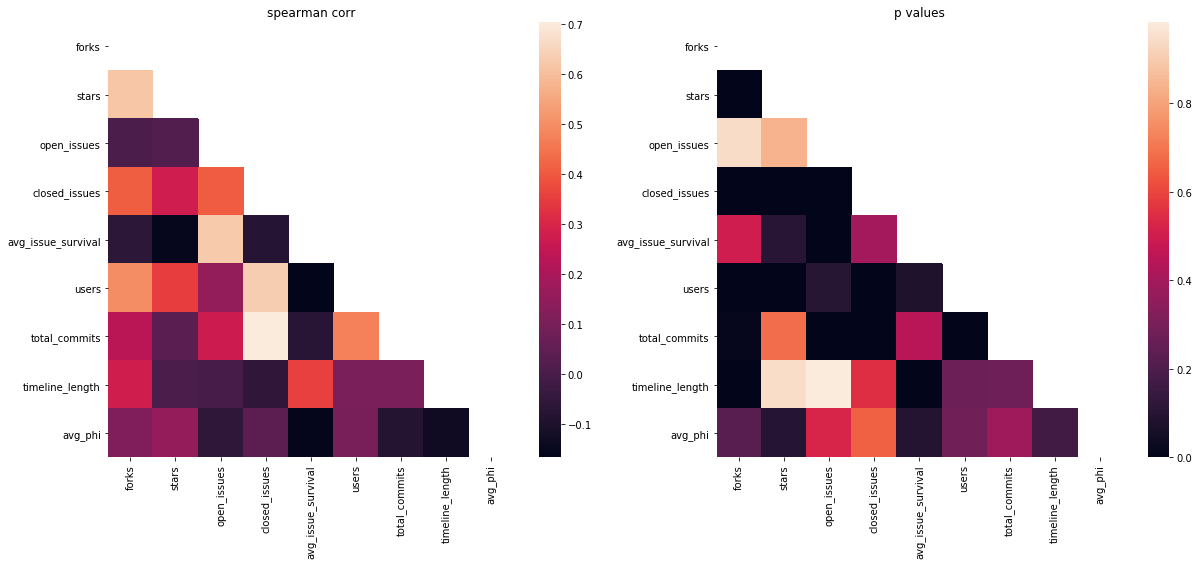

In [7]:
sp_cors = np.zeros(shape=(df.shape[1], df.shape[1]))
p_values = np.zeros(shape=(df.shape[1], df.shape[1]))
for i in range(df.shape[1]):
    for j in range(df.shape[1]):
        cor = sci_stats.spearmanr(df[df.columns[i]], df[df.columns[j]])
        sp_cors[i,j] = cor.correlation
        p_values[i,j] = cor.pvalue
sp_cors = pd.DataFrame(sp_cors, columns=df.columns, index=df.columns)
p_values = pd.DataFrame(p_values, columns=df.columns, index=df.columns)

plt.figure(figsize=(20,8))
plt.subplot(1,2,1)
plt.title('spearman corr')
sns.heatmap(sp_cors, mask=np.triu(np.ones(df.shape[1])))

plt.subplot(1,2,2)
plt.title('p values')
sns.heatmap(p_values, mask=np.triu(np.ones(df.shape[1])))

plt.show()

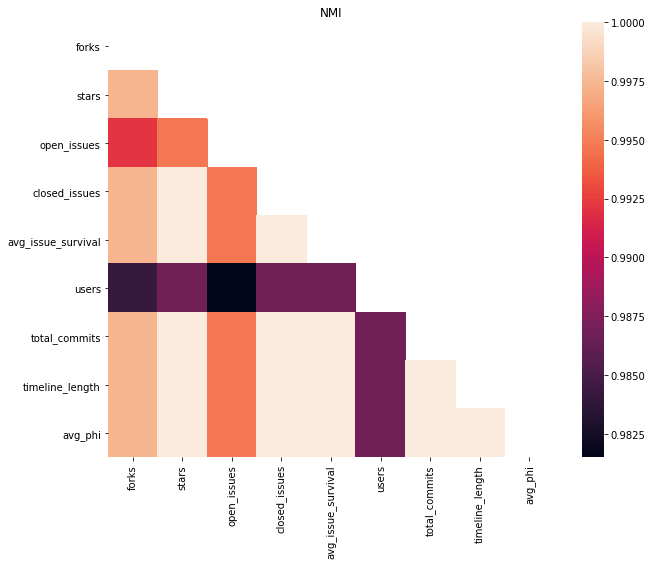

In [8]:
mis = np.zeros(shape=(df.shape[1], df.shape[1]))
for i in range(df.shape[1]):
    for j in range(df.shape[1]):
        mis[i,j] = normalized_mutual_info_score(df[df.columns[i]], df[df.columns[j]])
mis = pd.DataFrame(mis, columns=df.columns, index=df.columns)

plt.figure(figsize=(10,8))
plt.title('NMI')
sns.heatmap(mis, mask=np.triu(np.ones(df.shape[1])))
plt.show()

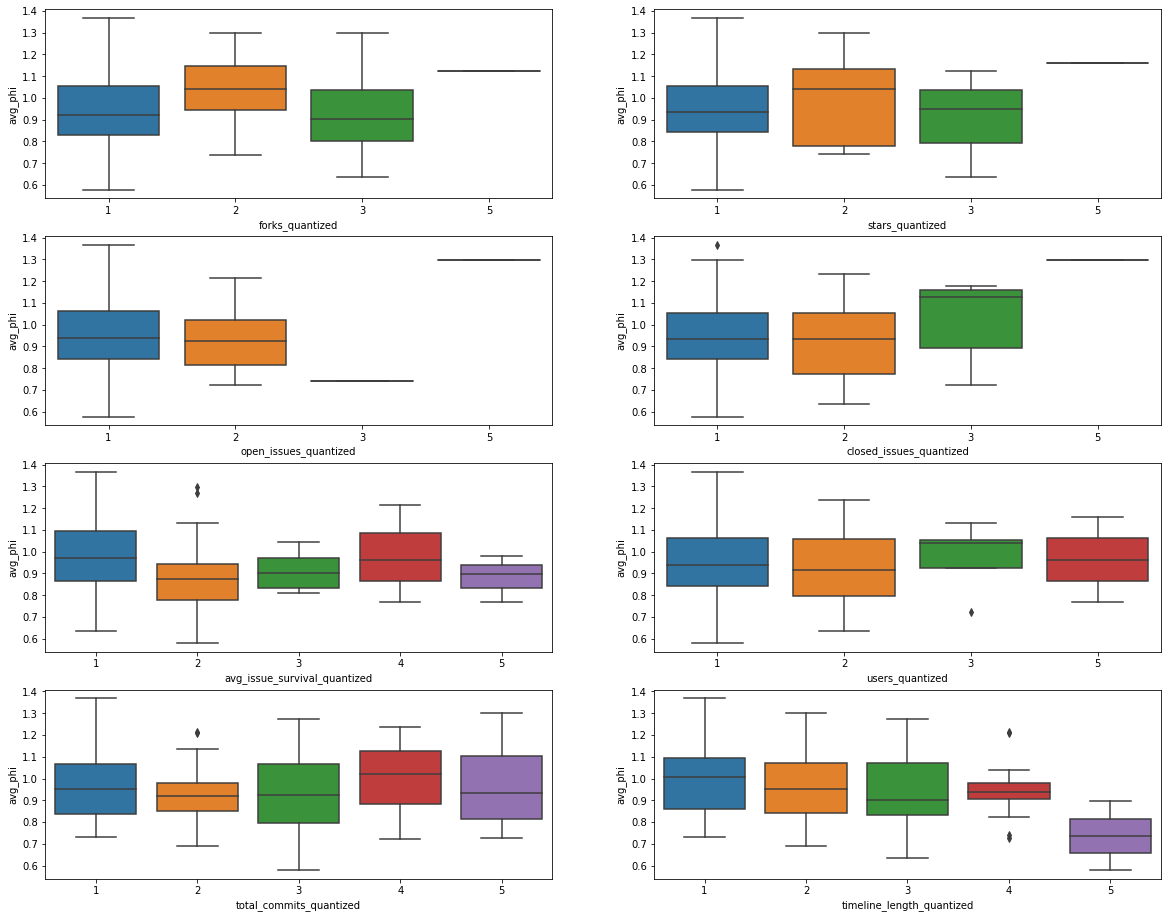

In [9]:
def quantize_col(data, col, n_bins=5):
    bins = np.linspace(np.min(data[col]), np.max(data[col])+1, n_bins+1)
    temp_df = data.copy()[[col, 'avg_phi']]
    temp_df[col+'_quantized'] = np.digitize(temp_df[col], bins=bins)   
    sns.boxplot(data=temp_df, x=col+'_quantized', y='avg_phi')

n = len(df.columns) - 1
plt.figure(figsize=(20,16))
for i,col in enumerate(df.drop(['avg_phi'], axis=1).columns):
    plt.subplot(n // 2 , 2, i+1)
    quantize_col(df, col, n_bins=5)
plt.show()

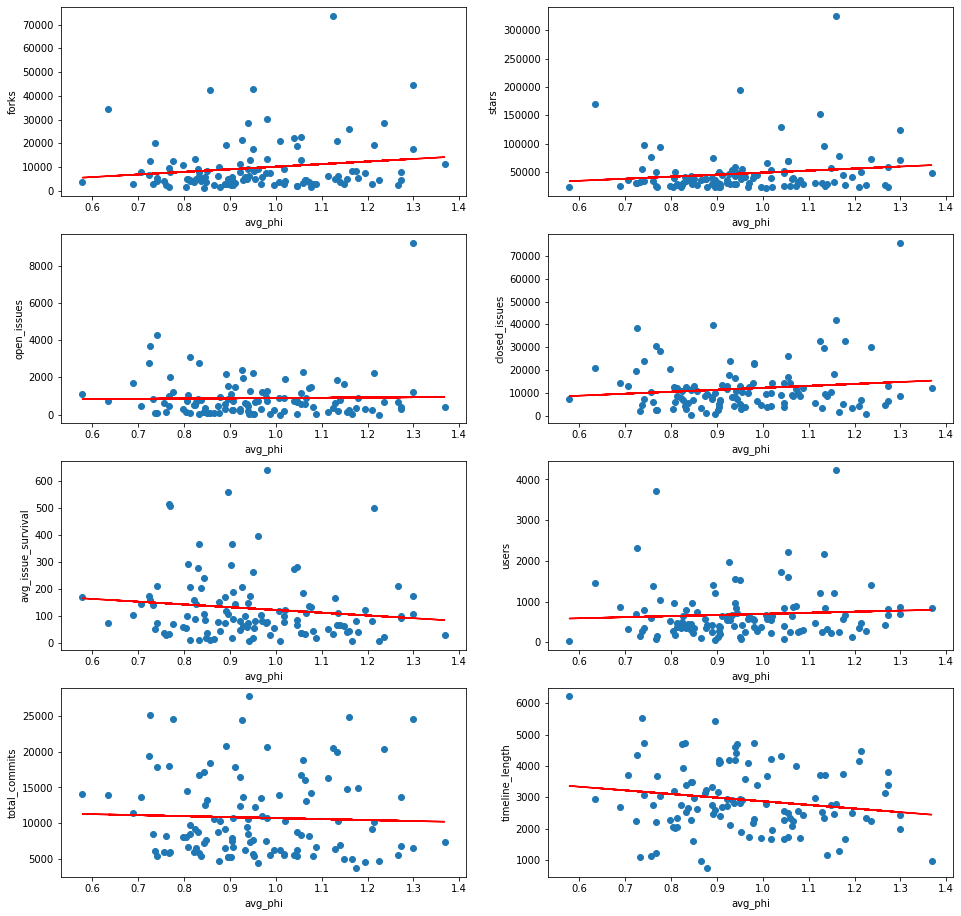

In [14]:
n = len(df.columns) - 1
standardize = lambda v : (v - v.mean()) / v.std()
x = df['avg_phi'].values

plt.figure(figsize=(16,16))
for i,col in enumerate(df.drop(['avg_phi'], axis=1).columns):
    y = df[col].values
    lr = LinearRegression().fit(x.reshape(-1,1),y)
    
    plt.subplot(n // 2, 2, i+1)
    plt.xlabel('avg_phi')
    plt.ylabel(col)
    plt.scatter(x=x, y=y)
    plt.plot(x, lr.predict(x.reshape(-1,1)), c='r')
    
plt.show()

In [15]:
def experiment_regression(data, keys : list):
    scale = StandardScaler()
    X_drop = data.drop(['avg_phi'] + keys, axis=1).values
    X = data.drop(['avg_phi'], axis=1).values
    X = scale.fit_transform(X)
    X_drop = scale.fit_transform(X_drop)
    y = data['avg_phi'].values

    lr_drop = SVR(kernel='poly')
    lr = SVR(kernel='poly')
    lr.fit(X, y)
    lr_drop.fit(X_drop, y)

    r2 = lr.score(X, y)
    r2_dropped = lr_drop.score(X_drop, y)
    print('full:', r2)
    print('dropped:', r2_dropped)
    LRT = 2 * (np.log(r2) - np.log(r2_dropped))
    p_value = chi2.sf(LRT, 1)
    print('p value:', p_value)

    pred = lr.predict(X)
    pred_drop = lr_drop.predict(X_drop)

    plt.figure(figsize=(20,10))
    plt.subplot(2,1,1)
    plt.title('full model')
    plt.plot(y)
    plt.plot(pred)

    plt.subplot(2,1,2)
    plt.title('restricted model')
    plt.plot(y)
    plt.plot(pred_drop)
    plt.show()

In [16]:
df.columns

Index(['forks', 'stars', 'open_issues', 'closed_issues', 'avg_issue_survival',
       'users', 'total_commits', 'timeline_length', 'avg_phi'],
      dtype='object')

full: 0.42351041854577365
dropped: 0.38813559110509976
p value: 0.6761897045346803


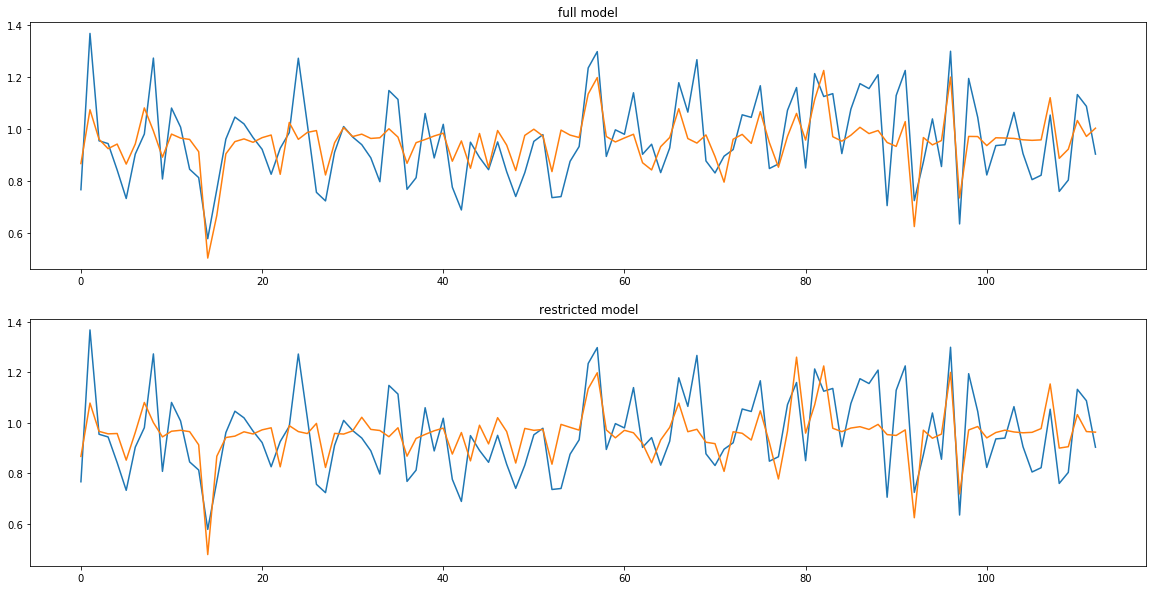

In [17]:
experiment_regression(df, keys=['avg_issue_survival'])